# Speech Emotion Recognition (CREMA Dataset)

## 0. Problem Statement

The main goal of this lab is to build a CNN model that detects human emotions from speech using the CREMA dataset, by turning speech clips into features that can help a computer recognize emotions like humans do.

## 1. Imports and Utilities

In [51]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML
from collections import defaultdict
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [52]:
# configurations
SEED = 42
SAMPLE_RATE = 22050 # number of audio samples captured per second
FRAME_LENGTH = 2048 # number of samples per analysis frame
HOP_LENGTH = 512    # samples between consecutive frame starts 
                    # instead of jumping the frame length we jump 512 so that the frames overlap to get smooth detailed analysis
DURATION = 3
TARGET_LENGTH = SAMPLE_RATE * DURATION
# compute the exact number of frames for 3s clips which will be (3*22050)/512 = 130
N_FRAMES = int(np.ceil(TARGET_LENGTH / HOP_LENGTH))
EMOTION_MAP = {
    'ANG': 'Angry', 'DIS': 'Disgust', 'FEA': 'Fear',
    'HAP': 'Happy', 'NEU': 'Neutral', 'SAD': 'Sad'
}

## 2. Dataset Loading and Visualizing

In [53]:

class DataLoader:
    def __init__(self,audio_dir="Crema/"):
        self.audio_dir = audio_dir
        self.file_groups = defaultdict(list)
        self.emotion_colors = {
            "ANG":"#d62728", "DIS":"#2ca02c","FEA":"#7f7f7f",
            "HAP":"#ff7f0e", "NEU":"#1f77b4","SAD":"#9467bd"
        }
        self.load_dataset()
        self.print_dataInfo_report()

    def load_dataset(self):
        n_files = 0
        for file_name in sorted(os.listdir(self.audio_dir)):
            if file_name.endswith('.wav'):
                parts = file_name.split("_")
                base_id = "_".join(parts[:2])
                emotion = parts[2]
                full_path = os.path.join(self.audio_dir,file_name)

                self.file_groups[base_id].append((emotion,full_path))
                n_files += 1
        print(f"Loaded {n_files} audio files")
        self.filter_groups()

    def filter_groups(self):
        self.file_groups = {k: v for k,v in self.file_groups.items() if len({item[0] for item in v}) > 1}

    def print_dataInfo_report(self):
        emotion_counts = defaultdict(int)
        for i in self.file_groups.values():
            for emotion, _ in i:
                emotion_counts[emotion] +=1

        display(HTML(
            f"<h2 style='color:#2c3e50; border-bottom: 3px solid #3498db;'>"
            "Dataset Info Report</h2>"
            f"<p style='font-size:16px;'>"
            f"Groups: {len(self.file_groups)}<br>"
            f"Emotion distribution:<br>"
            + "<br>".join([f" • {e}: {c} samples" for e,c in emotion_counts.items()]) +
            "</p>"
        ))

    def load_audio(self,path):
        signal,_ = librosa.load(path,sr=SAMPLE_RATE,duration=DURATION)
        return librosa.util.fix_length(signal,size=TARGET_LENGTH)
    
    def display_audio(self,signal,emotion):
        display(HTML(
            f"<div style='margin:10px 0; padding-left:8px; border-left: 3px solid {self.emotion_colors[emotion]}'>"
            f"<span style='color:{self.emotion_colors[emotion]}; font-weight:bold;'>{EMOTION_MAP[emotion]}</span> sample:"
            "</div>"
        ))
        display(Audio(data=signal,rate=SAMPLE_RATE))
    
    def plot_waveforms(self, n_groups=1):
        # plot all emotions with waveform for the same audio id
        groups = list(self.file_groups.keys())
        rng = np.random.default_rng(SEED)
        selected_groups = rng.choice(groups, size=min(n_groups, len(groups)), replace=False)

        for group_id in selected_groups:
            group_data = self.file_groups[group_id]
            emotions = [item[0] for item in group_data]
            
            # first pass load all signals and find global amplitude range
            signals = []
            global_max = 0
            for emotion, path in group_data:
                signal = self.load_audio(path)
                signals.append(signal)
                current_max = np.max(np.abs(signal))
                global_max = max(global_max, current_max)
            
            # 10% padding to amplitude range
            y_min = -global_max * 1.1
            y_max = global_max * 1.1
            
            # plots
            fig = plt.figure(figsize=(12, 3 * len(emotions)), dpi=100, 
                            constrained_layout=True)
            fig.suptitle(f"Emotion Waveforms: {group_id}", y=1.02, 
                        fontsize=16, fontweight='bold')
            
            for i, ((emotion, path), signal) in enumerate(zip(group_data, signals), 1):
                ax = fig.add_subplot(len(emotions), 1, i)
                time = np.linspace(0, DURATION, len(signal))
                
                ax.plot(time, signal, 
                        color=self.emotion_colors[emotion],
                        alpha=0.8,
                        linewidth=1.2)
                
                ax.set_title(f"{emotion} - {EMOTION_MAP[emotion]}",
                            color=self.emotion_colors[emotion],
                            fontsize=12,
                            pad=20,  
                            loc='left',
                            y=1.05,  
                            fontweight='bold')

                ax.set_ylim(y_min, y_max)
                ax.set_xlim(0, DURATION)
                ax.set_xlabel("Time (seconds)" if i == len(emotions) else "",
                            fontsize=10)
                ax.set_ylabel("Amplitude", fontsize=10)
                ax.tick_params(axis='both', labelsize=8)
                ax.grid(True, alpha=0.3)
                
                self.display_audio(signal, emotion)

            plt.show()

Loaded 7442 audio files


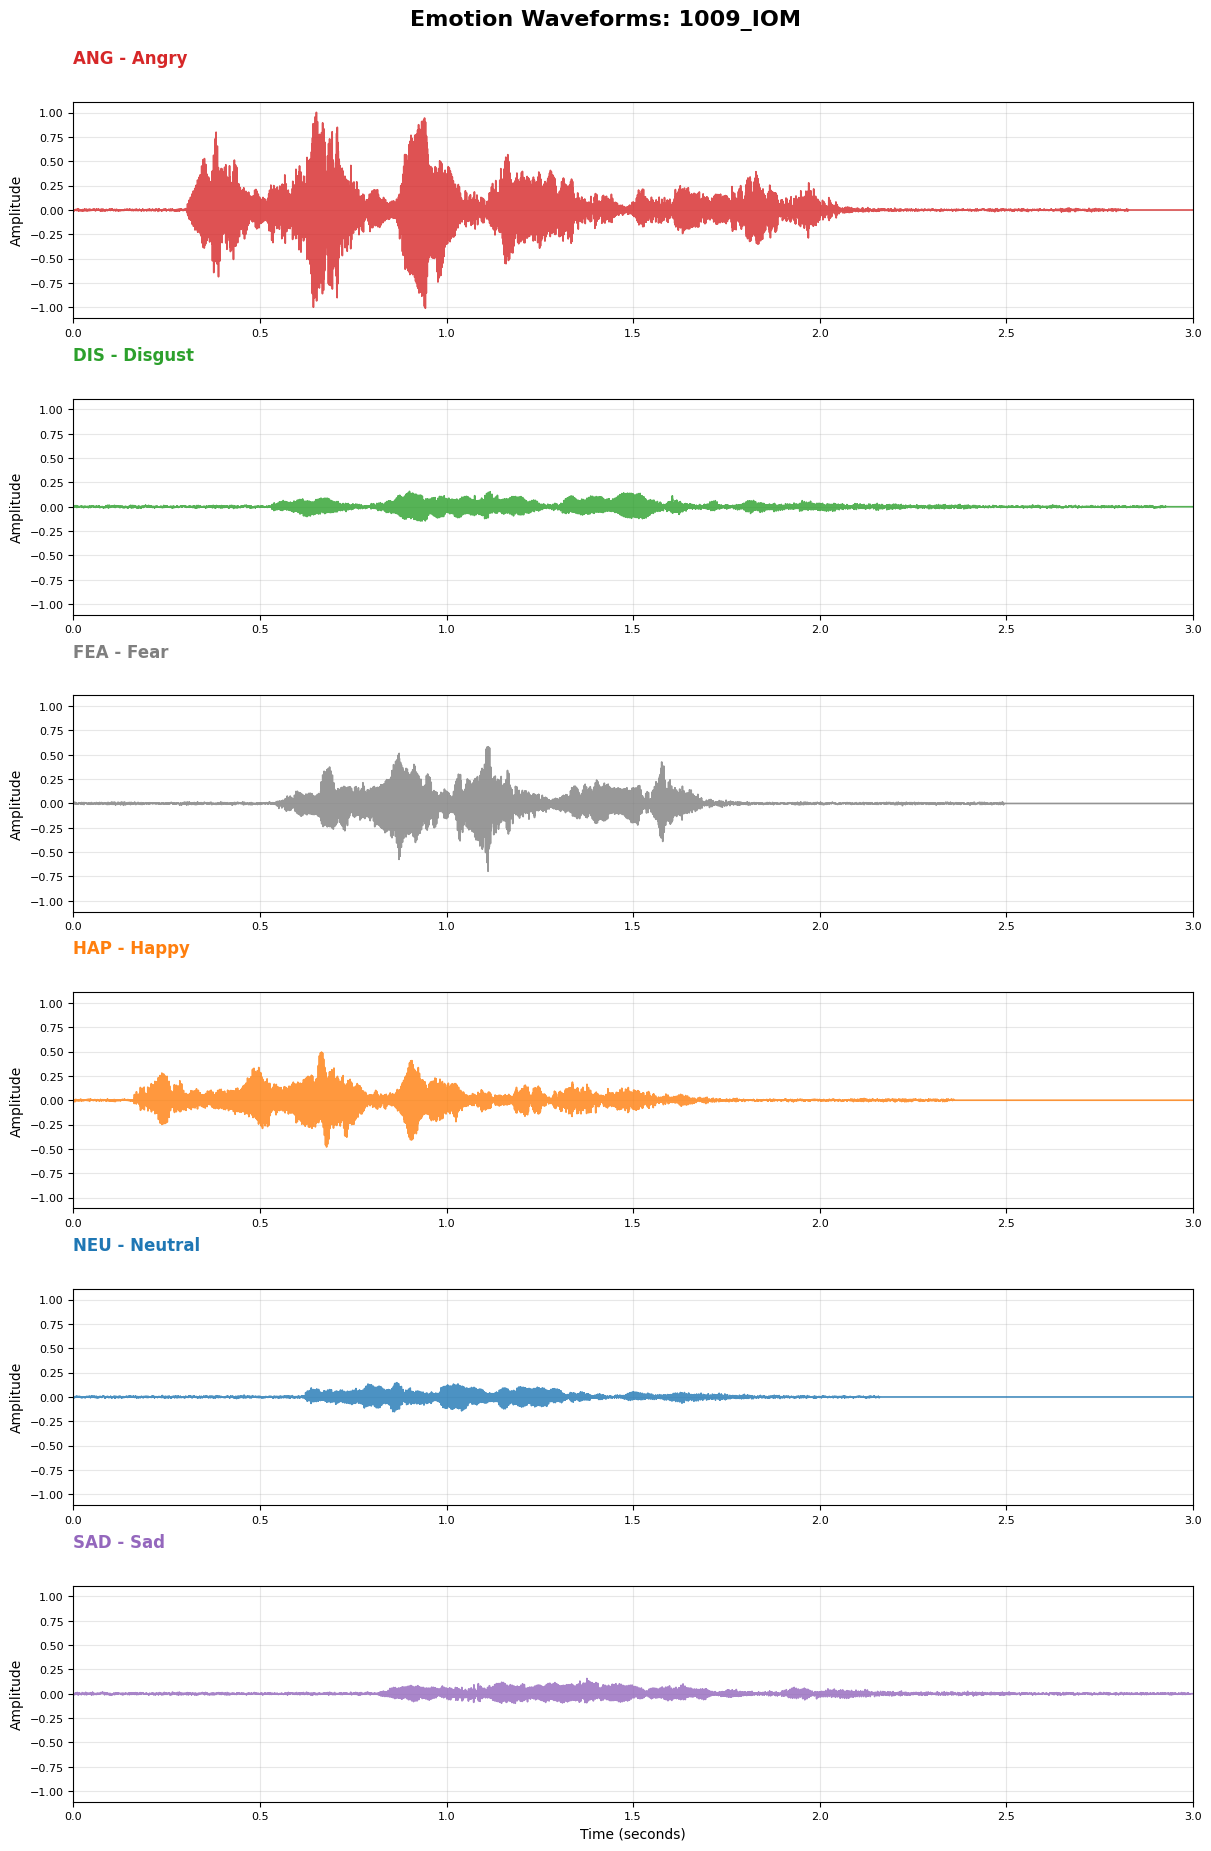

In [54]:
data_loader = DataLoader()
data_loader.plot_waveforms()

## 3. Create the Feature Space

In [1]:
class FeatureExtraction:
    def __init__(self):
        self.frame_length = FRAME_LENGTH
        self.hop_length = HOP_LENGTH
        self.n_frames = N_FRAMES

    def extract_time_features(self, signal):
        # 1. ZCR
        zcr = librosa.feature.zero_crossing_rate(
            y=signal,
            frame_length=self.frame_length,
            hop_length=self.hop_length
        )[0]

        # 2. RMS 
        rms = librosa.feature.rms(
            y=signal,
            frame_length=self.frame_length,
            hop_length=self.hop_length
        )[0]

        # 3. spectral centroid
        centroid = librosa.feature.spectral_centroid(
            y=signal,
            sr=SAMPLE_RATE,
            n_fft=self.frame_length,
            hop_length=self.hop_length
        )[0]

         # 3. spectral bandwidth
        bandwidth = librosa.feature.spectral_bandwidth(
            y=signal,
            sr=SAMPLE_RATE,
            n_fft=self.frame_length,
            hop_length=self.hop_length
        )[0]

        # spectral rolloff
        rolloff = librosa.feature.spectral_rolloff(
            y=signal,
            sr=SAMPLE_RATE,
            n_fft=self.frame_length,
            hop_length=self.hop_length,
            roll_percent=0.85
        )[0]

        def pad_trunc(x):
            return np.pad(x,
                          (0, max(0, self.n_frames - len(x))),
                          mode='constant'
                         )[:self.n_frames]

        zcr       = pad_trunc(zcr)
        rms       = pad_trunc(rms)
        centroid  = pad_trunc(centroid)
        bandwidth = pad_trunc(bandwidth)
        rolloff   = pad_trunc(rolloff)

        features = np.stack([zcr, rms, centroid, bandwidth, rolloff], axis=1)
        return features
 
    def extract_mel_spectrogram(self,signal):
        mel_spec = librosa.feature.melspectrogram(y=signal,sr=SAMPLE_RATE,n_fft=self.frame_length,hop_length=self.hop_length,n_mels=128)
        mel_db = librosa.power_to_db(mel_spec,ref=np.max)
        resized = resize(mel_db,(128,128),anti_aliasing=True)
        return resized[..., np.newaxis]

## 4. Build Model

### 4.1 Data Split

In [56]:
class DataSplitter:
    @staticmethod
    def split(X_time, X_mel, y, test_size=0.3, val_size=0.05, random_state=SEED):
        indices = np.arange(len(y))
        # initial train test split
        train_val_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size,
            stratify=y,
            random_state=random_state
        )

        # validation split
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=val_size/(1-test_size),
            stratify=y[train_val_idx],
            random_state=random_state
        )

        X_train_time, X_val_time, X_test_time = X_time[train_idx], X_time[val_idx], X_time[test_idx]
        X_train_mel, X_val_mel, X_test_mel = X_mel[train_idx], X_mel[val_idx], X_mel[test_idx]
        y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]
        
        return (X_train_time, X_val_time, X_test_time,
                X_train_mel, X_val_mel, X_test_mel,
                y_train, y_val, y_test)

In [57]:
# feature extraction
extractor = FeatureExtraction()
time_features = []
mel_features = []
labels = []

# collecting all data
for id, items in data_loader.file_groups.items():
    for emotion, path in items:
        signal = data_loader.load_audio(path)
        time_features.append(extractor.extract_time_features(signal))
        mel_features.append(extractor.extract_mel_spectrogram(signal))
        labels.append(emotion)

X_time = np.array(time_features)
X_mel = np.array(mel_features)

# encode labels
le = LabelEncoder().fit(labels)
y = le.transform(labels)

print("Data shapes:")
print("-" * 20)
print(f"Time features: {X_time.shape}")
print(f"Mel spectrograms: {X_mel.shape}")

Data shapes:
--------------------
Time features: (7442, 130, 2)
Mel spectrograms: (7442, 128, 128, 1)


In [58]:
# data splitting
splitter = DataSplitter()
(X_train_time, X_val_time, X_test_time,
 X_train_mel, X_val_mel, X_test_mel,
 y_train, y_val, y_test) = splitter.split(X_time, X_mel, y)

assert X_train_time.shape[1:] == (N_FRAMES, 2)
assert X_train_mel.shape[1:]  == (128, 128, 1)

print("Time features shapes:", X_train_time.shape, X_val_time.shape, X_test_time.shape)
print("Mel features shapes:", X_train_mel.shape, X_val_mel.shape, X_test_mel.shape)
print("Labels:", np.unique(y_train, return_counts=True))

Time features shapes: (4836, 130, 2) (373, 130, 2) (2233, 130, 2)
Mel features shapes: (4836, 128, 128, 1) (373, 128, 128, 1) (2233, 128, 128, 1)
Labels: (array([0, 1, 2, 3, 4, 5]), array([825, 826, 826, 826, 707, 826]))


### 4.2 CNN Model

## 5. Evaluation and Comparison